In [1]:
import yaml
import numpy as np
import zstandard as zstd
import os
from TraceSimulator import TraceSimulator

def read_yaml_to_dict(file_path):
    with open(file_path, 'r') as file:
        config_dict = yaml.safe_load(file)
    return config_dict

config = read_yaml_to_dict('../archive/config.yaml')
ts = TraceSimulator(config)

In [2]:
import yaml
import numpy as np
import zstandard as zstd
import os
from TraceSimulator import TraceSimulator

def read_yaml_to_dict(file_path):
    with open(file_path, 'r') as file:
        config_dict = yaml.safe_load(file)
    return config_dict

def save_traces_to_zstd(traces, output_path, dtype=np.float16, trace_shape=(54, 32768), compression_level=15):
    """
    Save a list of numpy arrays (traces) into a compressed Zstandard (.zst) file.
    """
    def shuffle_bytes(arr: np.ndarray) -> bytes:
        return arr.view(np.uint8).reshape(-1, arr.itemsize).T.tobytes()

    all_data = bytearray()
    for trace in traces:
        if trace.shape != trace_shape:
            raise ValueError(f"Trace has wrong shape {trace.shape}, expected {trace_shape}")
        shuffled = shuffle_bytes(trace.astype(dtype))
        all_data.extend(shuffled)

    compressor = zstd.ZstdCompressor(level=compression_level)
    compressed_data = compressor.compress(bytes(all_data))

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with open(output_path, 'wb') as f:
        f.write(compressed_data)

def load_traces_from_zstd(input_path, n_traces, dtype=np.float16, trace_shape=(54, 32768)) -> np.ndarray:
    """
    Load a list of numpy arrays (traces) from a compressed Zstandard (.zst) file and return a single stacked ndarray.
    """
    def unshuffle_bytes(data: bytes, dtype=np.float16, shape=(54, 32768)) -> np.ndarray:
        itemsize = np.dtype(dtype).itemsize
        num_elements = np.prod(shape)
        reshaped = np.frombuffer(data, dtype=np.uint8).reshape(itemsize, num_elements).T
        unshuffled = reshaped.reshape(-1)
        return unshuffled.view(dtype).reshape(shape)

    decompressor = zstd.ZstdDecompressor()
    with open(input_path, 'rb') as f:
        compressed_content = f.read()
        decompressed = decompressor.decompress(compressed_content)

    trace_size_bytes = np.prod(trace_shape) * np.dtype(dtype).itemsize
    expected_size = n_traces * trace_size_bytes
    if len(decompressed) != expected_size:
        raise ValueError("Decompressed size does not match expected size")

    traces = []
    for i in range(n_traces):
        start = i * trace_size_bytes
        end = start + trace_size_bytes
        trace_bytes = decompressed[start:end]
        trace = unshuffle_bytes(trace_bytes, dtype=dtype, shape=trace_shape)
        traces.append(trace)

    return np.stack(traces)

# Example usage (replace with actual TraceSimulator)
# ts = TraceSimulator(read_yaml_to_dict("config.yaml"))
# energy = 50
# n_sets = 100
# all_traces = []
# for _ in range(n_sets):
#     trace, _ = ts.generate(energy, type_recoil='NR', no_noise=False)
#     all_traces.append(np.asarray(trace, dtype=np.float16))
#
# save_traces_to_zstd(all_traces, f"compressed_traces/traces_energy_{energy}.zst")
# loaded_traces = load_traces_from_zstd(f"compressed_traces/traces_energy_{energy}.zst", n_traces=n_sets)


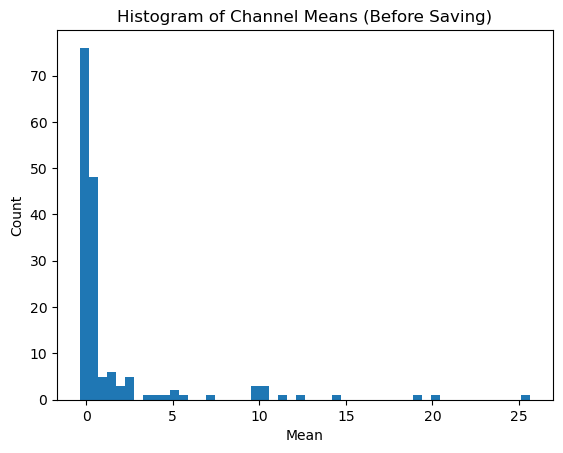

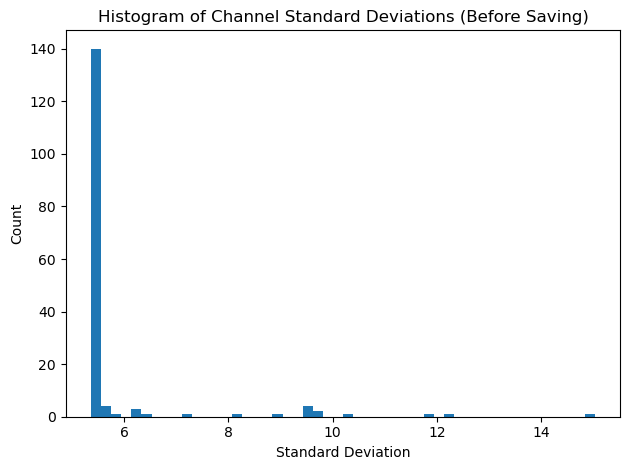

In [5]:
import matplotlib.pyplot as plt

energy = 500
n_sets = 3
all_traces = []
all_means = []
all_stds = []

for _ in range(n_sets):
    trace = ts.generate(
        E=energy,
        x=-40, y=80, z=-1800,
        no_noise=False,
        type_recoil='NR',
        quantize=True,
        phonon_only=False
    ) # simulate single (1, 54, 32768) trace
    trace = np.asarray(trace[0], dtype=np.float16)  # shape: (54, 32768)
    all_traces.append(trace)

    # Convert to float32 for numerical stability in calculations
    trace_f32 = trace.astype(np.float32)
    means = trace_f32.mean(axis=-1)  # shape: (54,)
    stds = trace_f32.std(axis=-1)    # shape: (54,)

    all_means.extend(means)
    all_stds.extend(stds)


# Convert to numpy arrays for histogram plotting
all_means = np.array(all_means)
all_stds = np.array(all_stds)

# Plot histograms
fig1, ax1 = plt.subplots()
ax1.hist(all_means, bins=50)
ax1.set_title("Histogram of Channel Means (Before Saving)")
ax1.set_xlabel("Mean")
ax1.set_ylabel("Count")

fig2, ax2 = plt.subplots()
ax2.hist(all_stds, bins=50)
ax2.set_title("Histogram of Channel Standard Deviations (Before Saving)")
ax2.set_xlabel("Standard Deviation")
ax2.set_ylabel("Count")

plt.tight_layout()
plt.show()


save_traces_to_zstd(all_traces, f"compressed_traces/traces_energy_{energy}.zst")
loaded_traces = load_traces_from_zstd(f"compressed_traces/traces_energy_{energy}.zst", n_traces=n_sets)

In [6]:
import matplotlib.pyplot as plt

def plot_trace_set(trace_set):
    """
    Plot all 54 channels of a single trace set (shape: (54, 32768))
    """
    
    fig, axs = plt.subplots(9, 6, figsize=(20, 10), sharex=True)
    axs = axs.flatten()
    for ch in range(54):
        axs[ch].plot(trace_set[ch])
        axs[ch].set_title(f'Ch {ch}')
    plt.tight_layout()
    plt.show()


--- Trace Set 0 ---


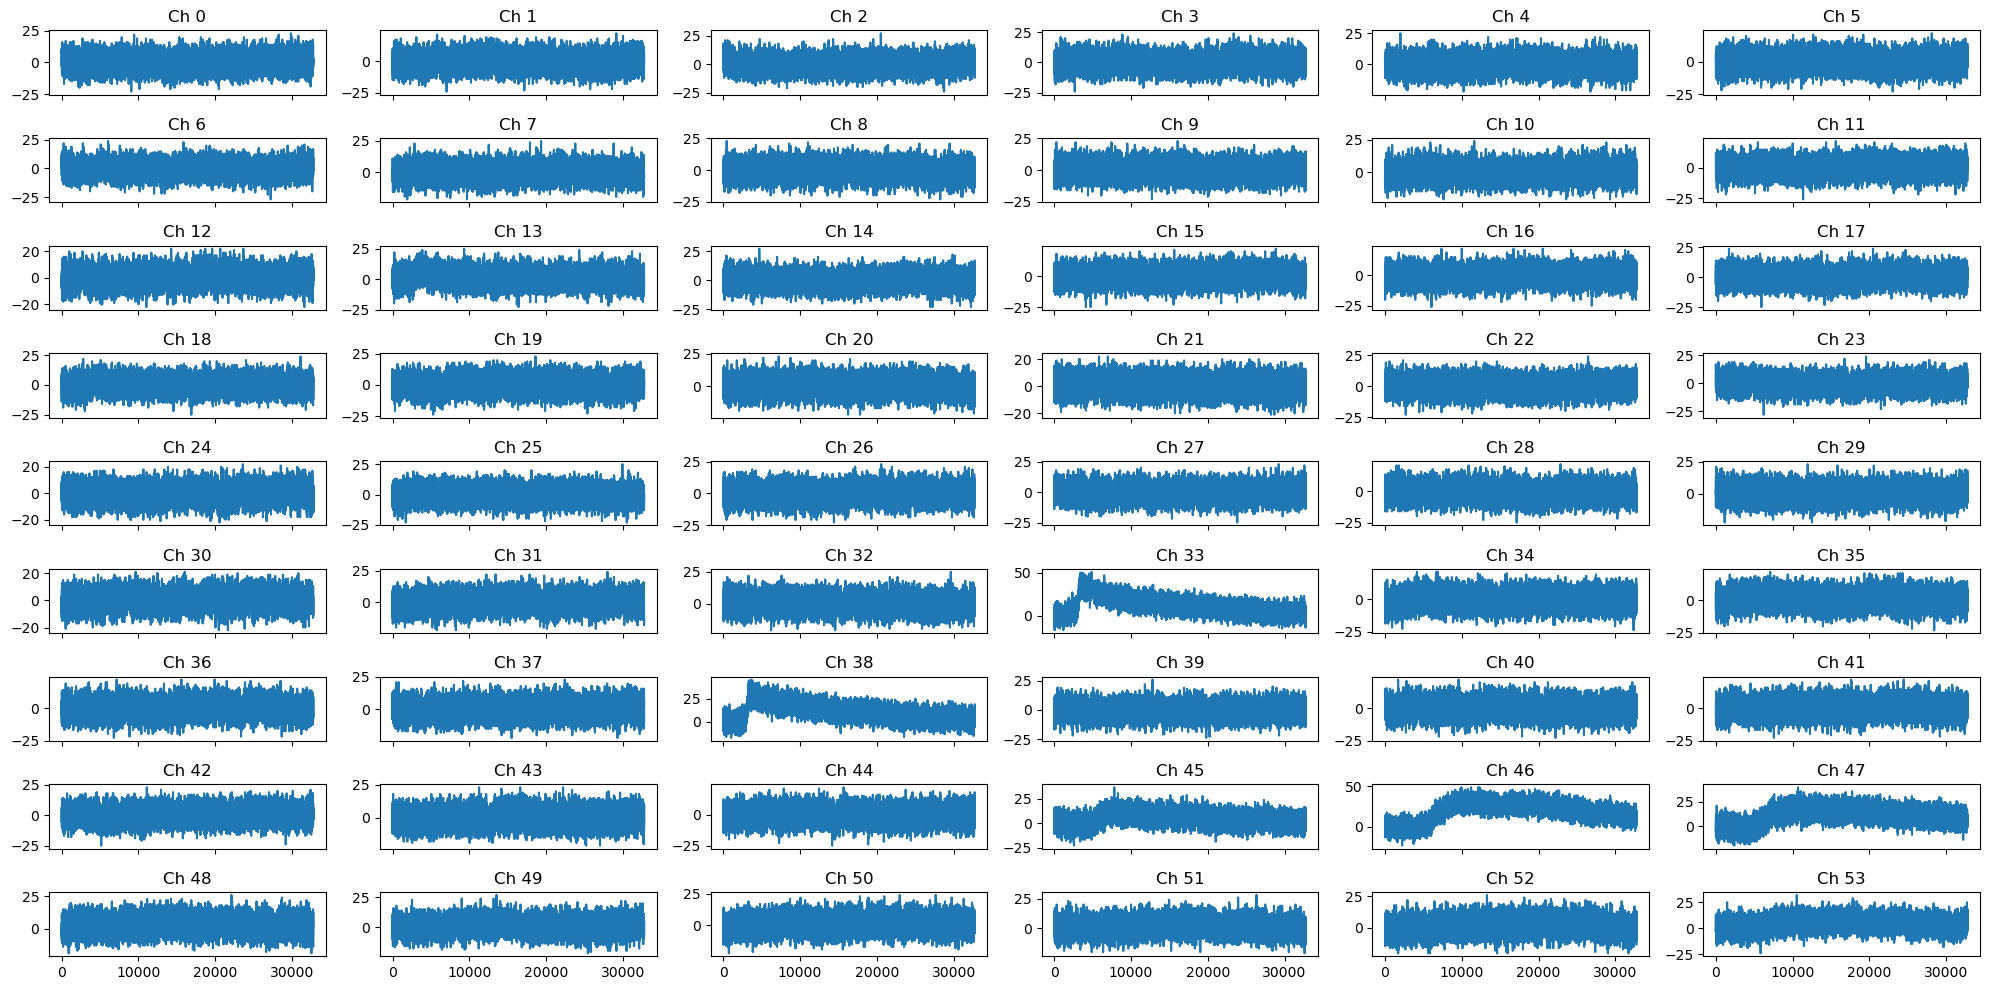

Means:
 [ 1.0510254e-01 -3.6987305e-01  3.0728149e-01  2.9220581e-01
 -7.1472168e-02 -1.5829468e-01 -3.1857300e-01 -3.6047363e-01
 -3.1497192e-01  8.6120605e-02 -8.4533691e-03 -1.6510010e-02
  3.5974121e-01  1.1807556e+00  7.1075439e-02 -4.0649414e-02
 -2.9077148e-01  2.9476929e-01  6.0577393e-02  3.6294556e-01
  3.7271118e-01  3.4140015e-01  2.7404785e-02 -2.1426392e-01
 -3.2409668e-02 -2.5125122e-01 -2.5558472e-01 -3.1622314e-01
 -3.4487915e-01  3.5842896e-01  2.6840210e-01  3.6740112e-01
  2.8015137e-01  1.1423340e+01 -3.7670898e-01  9.2489624e-01
 -1.1404419e-01  5.1452637e-02  1.0312958e+01 -3.7600708e-01
 -2.3052979e-01 -6.6162109e-02  2.5360107e-01  7.7850342e-02
 -3.6877441e-01  4.5322266e+00  1.8911926e+01  1.0489929e+01
  2.6532898e+00  1.0342712e+00  9.9942017e-01  1.4672546e+00
  1.5845947e+00  4.2019653e+00]
Stds:
 [ 5.3718767  5.374271   5.373356   5.3723     5.370867   5.3713365
  5.3734655  5.3727     5.3776345  5.374208   5.3745303  5.3716493
  5.3759975  5.4937334  5.

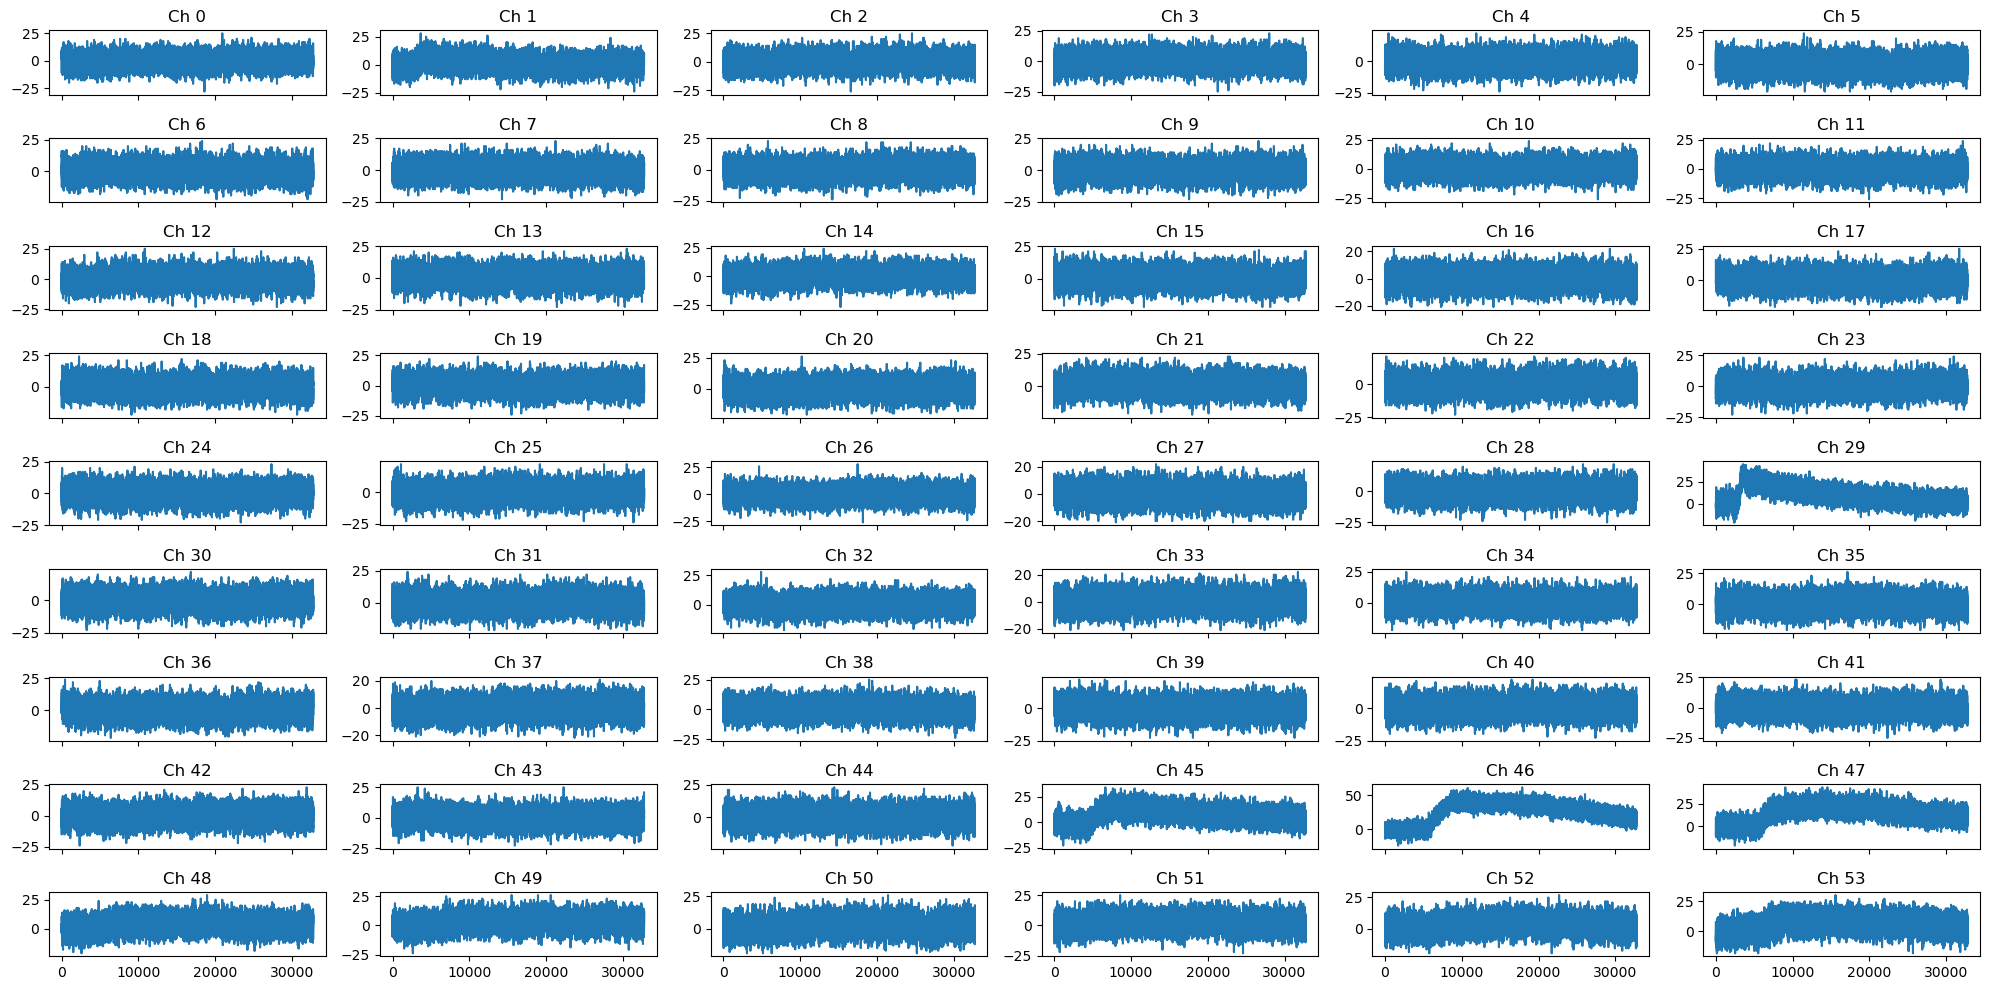

Means:
 [ 0.05047607  1.25177     0.3517456   0.2350769  -0.14859009 -0.36053467
  0.37423706 -0.36895752 -0.32681274 -0.36798096  0.19091797 -0.3201294
  0.14282227  0.32589722  0.3416443   0.1812439  -0.35159302  0.37420654
  0.09893799  0.34448242  0.03341675  1.007843   -0.0954895   0.18389893
 -0.32247925 -0.34588623 -0.1816101  -0.34695435 -0.07052612  9.6397705
 -0.34439087  0.24172974  0.17285156  0.34707642  0.3333435   0.3758545
 -0.05899048 -0.37435913  0.35958862 -0.35232544  0.3434143  -0.24298096
  0.04037476 -0.3735962  -0.06234741  6.9564514  25.660645   14.437195
  3.4799194   2.2980042   1.9339294   1.9483643   2.6654358   5.3771667 ]
Stds:
 [ 5.3702016  5.5423145  5.373409   5.373388   5.3710055  5.3745985
  5.3754306  5.377218   5.373499   5.372691   5.3746977  5.3728304
  5.3757024  5.3694124  5.375887   5.375058   5.375103   5.3740673
  5.3745723  5.3745613  5.372258   5.4398427  5.3748927  5.370563
  5.374391   5.374806   5.3732805  5.376154   5.376459   9.527378

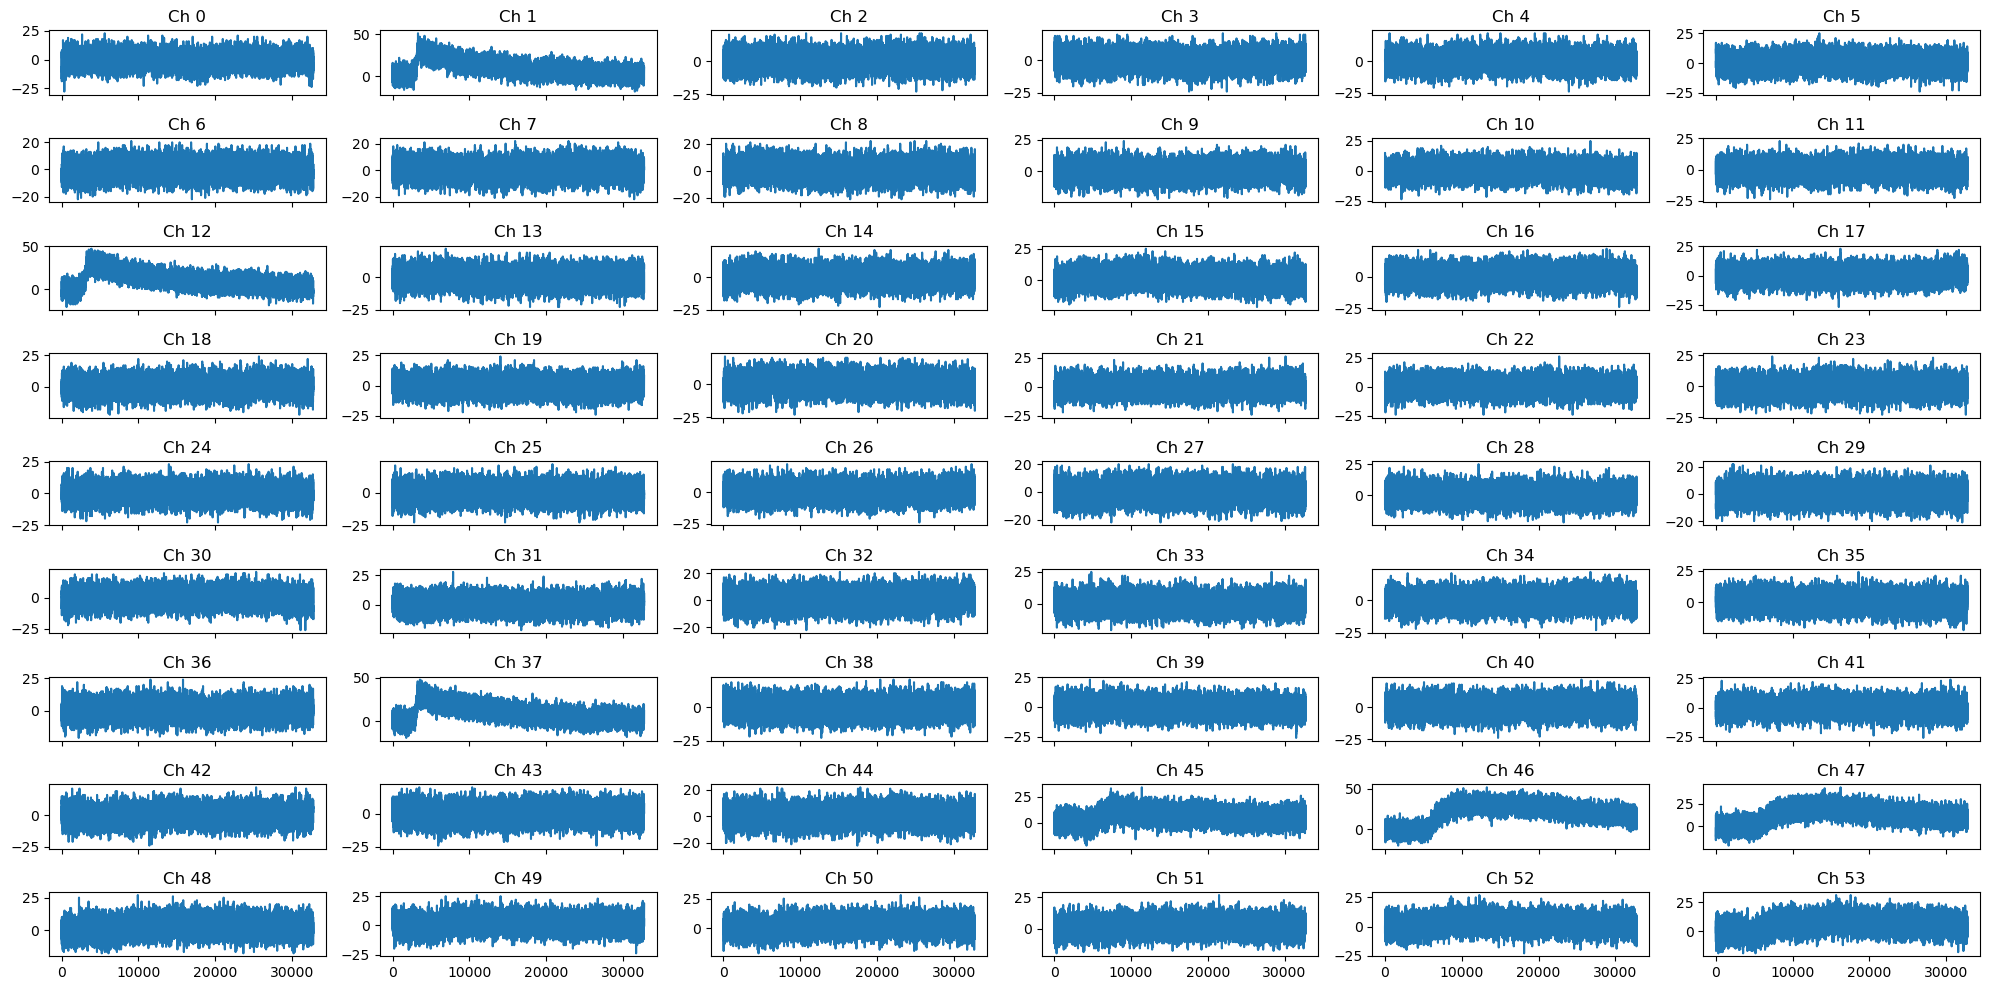

Means:
 [-0.2338562   9.917969    0.2720337  -0.1638794   0.3772583   0.3388672
 -0.22619629  0.16018677  0.18197632 -0.06820679 -0.03271484 -0.37283325
 10.193787   -0.37734985 -0.02944946  1.2217712   0.34933472  0.37609863
  0.35229492 -0.33847046  0.3555298  -0.2545166   0.3763733  -0.3659668
  0.0272522  -0.3520813   0.03662109 -0.32785034  0.21560669 -0.15493774
 -0.10192871  0.34573364  0.34039307  0.23052979  0.20874023  0.32373047
  0.34942627  9.565399   -0.30874634 -0.32772827  0.31463623  0.03936768
 -0.14111328  0.02624512  0.36843872  5.323761   20.053406   12.335388
  2.4350586   1.4906311   1.776886    1.6243896   2.3145447   5.0854797 ]
Stds:
 [ 5.374571   9.626051   5.3737483  5.376629   5.3749557  5.374589
  5.3746977  5.376698   5.377026   5.3747005  5.3721404  5.3769417
  9.605944   5.3751564  5.372781   5.4803267  5.3745294  5.371834
  5.3736405  5.3748155  5.3744216  5.3777227  5.376088   5.375895
  5.373968   5.376008   5.374495   5.3717875  5.3724265  5.3725195

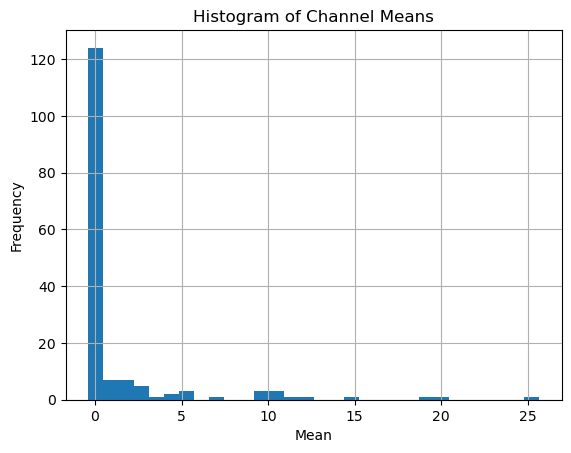

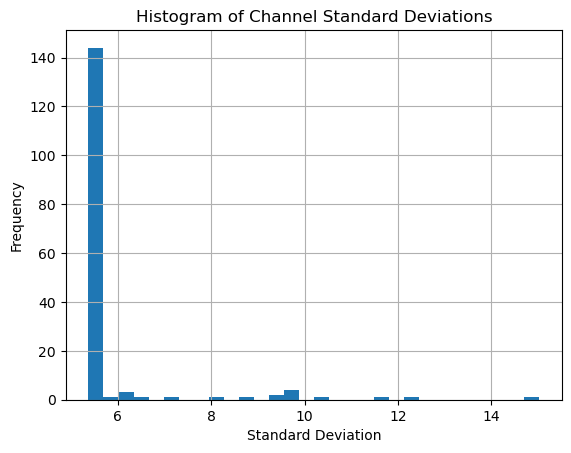

In [9]:
import numpy as np
import matplotlib.pyplot as plt

n_trace_sets = loaded_traces.shape[0]  # should be 2
n_channels = loaded_traces.shape[1]    # should be 54

channel_means = np.zeros((n_trace_sets, n_channels), dtype=np.float32)
channel_stds = np.zeros((n_trace_sets, n_channels), dtype=np.float32)

for i in range(n_trace_sets):
    trace_set = loaded_traces[i].astype(np.float32)  # Convert to float32 before processing

    print(f"\n--- Trace Set {i} ---")
    plot_trace_set(trace_set)  # Optional visualization

    means = trace_set.mean(axis=-1)  # shape: (54,)
    stds = trace_set.std(axis=-1)    # shape: (54,)
    
    print("Means:\n", means)
    print("Stds:\n", stds)

    channel_means[i] = means
    channel_stds[i] = stds

# Plot histograms
plt.figure()
plt.hist(channel_means.flatten(), bins=30)
plt.title("Histogram of Channel Means")
plt.xlabel("Mean")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

plt.figure()
plt.hist(channel_stds.flatten(), bins=30)
plt.title("Histogram of Channel Standard Deviations")
plt.xlabel("Standard Deviation")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()
